In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        '''children :  digunakan untuk tracking nilai yang mendahului nilai sekarang
            op  : operasi yang dilakukan atas value pada prev yang membentuk nilai saat ini'''
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda:None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            #chain rule
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data , (self, other), '*')
        def _backward():
            #chain rule
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out


    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def exp(self):
        x  = self.data
        out = Value(math.exp(x), (self,),  'exp')
        def _backward():
            #chain rule
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other, (int,float)) , 'only suporting int/float powers for now'
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            #chain rule
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # backward pada seluruh node
        # tujuaanya agar kita tidak perlu memanggil _backward satu persatu pada masing2 node
        # pertama kita membuat list yang berisi tiap2 node yang telah diurutkan mulai dari child ke parent menggunakan fungsi topological sort
        # kemudian dengan me reverse list ini, kita bisa memanggil _backward untuk tiap2 node untuk menjalankan backpropagation
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        draw_dot(o)



In [ ]:
a = Value(2.0)
b = Value(3.0)
a/b

Value(data=0.6666666666666666)

Bagaimana _backward ini bekerja?
            # self.grad disini merujuk kepada objek sebelum dilakukannya operasi tanh
            # dimana out._backward pada objek out membawa/memiliki referensi ke objek pembentuknya dalam hal ini adalah self
            # contohnya:
            # o = n.tanh()
            # ketika n.tanh() dipanggil dan di assign ke variable o
            # sebelum mengembalikan nilai out ke o, method_backward di assign ke attribute out._backward yang membawa referensi objek n didalamnya
            # sehingga ketika method _backward dipanggil pada objek o , self.grad (disini sebenarnya adalah n.grad) akan diupdate
            # hal yang sama juga berlaku pada method2 yang lain (__add__, __mul__,__sub__)

Bagaimana melakukan automasi pada proses backpropagation?
        # kita tahu bahwa proses backpropagation dimulai dari node terakhir (paling kanan)
        # idenya adalah membuat list yang berisikan node2 yang sudah diurutkan
        # Untuk mengurutkan node2 nya kita menggunakan fungsi topological sort
        # setelah node2 nya diurutkan kita hanya perlu memanggil fungsi _backward untuk tiap2 node

In [ ]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes in a graph
    nodes , edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir' : 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{%s | data %.4f| grad %.4f}" % (n.label,n.data,n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)

            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
# inputs x
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias
b = Value(6.88137, label ='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label  = 'o'

In [ ]:
o.backward()

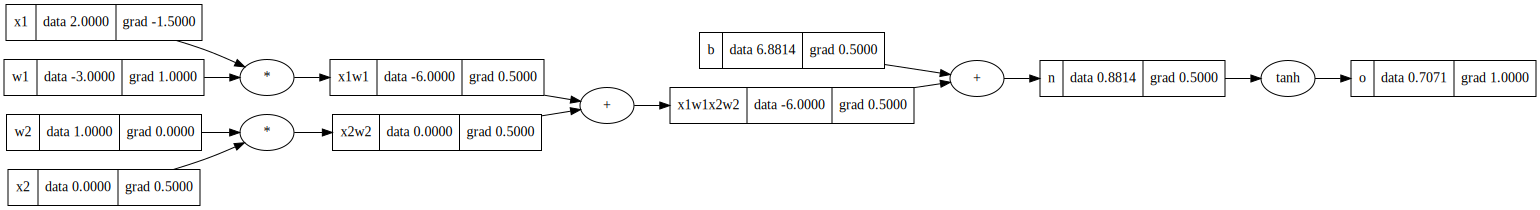

In [ ]:
draw_dot(o)

In [ ]:
class Neuron:
    def __init__(self, input_nums):
        '''
        pada 1 pasangan layer
        input_nums : jumlah neuron/feature pada input layer
        w : sebuah list yang berisi weight sejumlah jumlah feature input
        b : bias berupa scalar
        '''
        self.w =[Value(np.random.uniform(-1,1)) for _ in range(input_nums)]
        self.b = Value(np.random.uniform(-1,1))

    def parameters(self):
        return self.w + [self.b]
    def __call__(self,x):
        # w * x + b
        '''
        act : linear transformasi dari w dan x
        out : output setelah ditrannsformasi dengan acivation function/ forward propagation
        '''
        act = sum((w1*x1 for w1,x1 in zip(self.w , x)), start = self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, input_num, output_num):
        '''
        pada 1 pasangan layer
        input_num : jumlah neuron/feature pada input layer
        output_num : jumlah neuron/feature pada output layer
        neurons : merupakan list yang berisikan kumpulan objek Neuron sebanyak output layer
        outs : proses forward propagation
        '''
        self.neurons = [Neuron(input_num) for _ in range(output_num)]


    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if (len(outs) == 1) else outs

class MLP:
    '''
    sz : list yang merepresentasikan junlah layer dari MLP
    input_num : jumlah neuron dalam input layer
    output_nums[:-1] : list yang berisikan jumlah neuron untuk tiap hidden layer
    output_nums[-1] : jumlah neuron pada output layer
    layers : list yang berisi objek yang merupakan pasangan layer untuk tiap layer
    '''
    def __init__(self, input_num, output_nums):
        sz = [input_num] + output_nums
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(output_nums))]

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
n = MLP(3, [4,4,1])

In [ ]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for i in range(1000):
    y_pred = [n(x) for x in xs]
    loss = sum((yhat - ygt)**2 for ygt,yhat in zip(ys,y_pred))
    # set semua gradien menjadi 0 sebelum memanggil backward untuk setiap 1 iterasi training
    for param in n.parameters():
        param.grad = 0.0

    for param in n.parameters():
        param.data -= param.grad * 0.05

    if i%100 == 0:
        print(i , ' ---> ' ,loss.data)
y_pred = [n(x) for x in xs]
print(y_pred)


0  --->  0.002536287173536522
100  --->  0.002536287173536522
200  --->  0.002536287173536522
300  --->  0.002536287173536522
400  --->  0.002536287173536522
500  --->  0.002536287173536522
600  --->  0.002536287173536522
700  --->  0.002536287173536522
800  --->  0.002536287173536522
900  --->  0.002536287173536522
[Value(data=0.973794731243126), Value(data=-0.9907637790126133), Value(data=-0.9641596886370885), Value(data=0.9780971379450485)]
